In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json

from acoustic_loc.utils import (
    load_scene_from_h5,
    load_scene_metadata,
    find_peaks_on_map, 
)


In [2]:
h5_path = Path("../data/processed/train.h5")
with h5py.File(h5_path, "r") as f:
    print(list(f.keys()))
    for name in ["pressure_real", "pressure_imag", "source_maps", "sample_ids"]:
        print(name, f[name].shape, f[name].dtype)


['pressure_imag', 'pressure_real', 'sample_ids', 'source_maps']
pressure_real (8000, 256, 256) float32
pressure_imag (8000, 256, 256) float32
source_maps (8000, 256, 256) float32
sample_ids (8000,) int64


Сэмпл 5004 найден в 'train.h5' по индексу 6445.


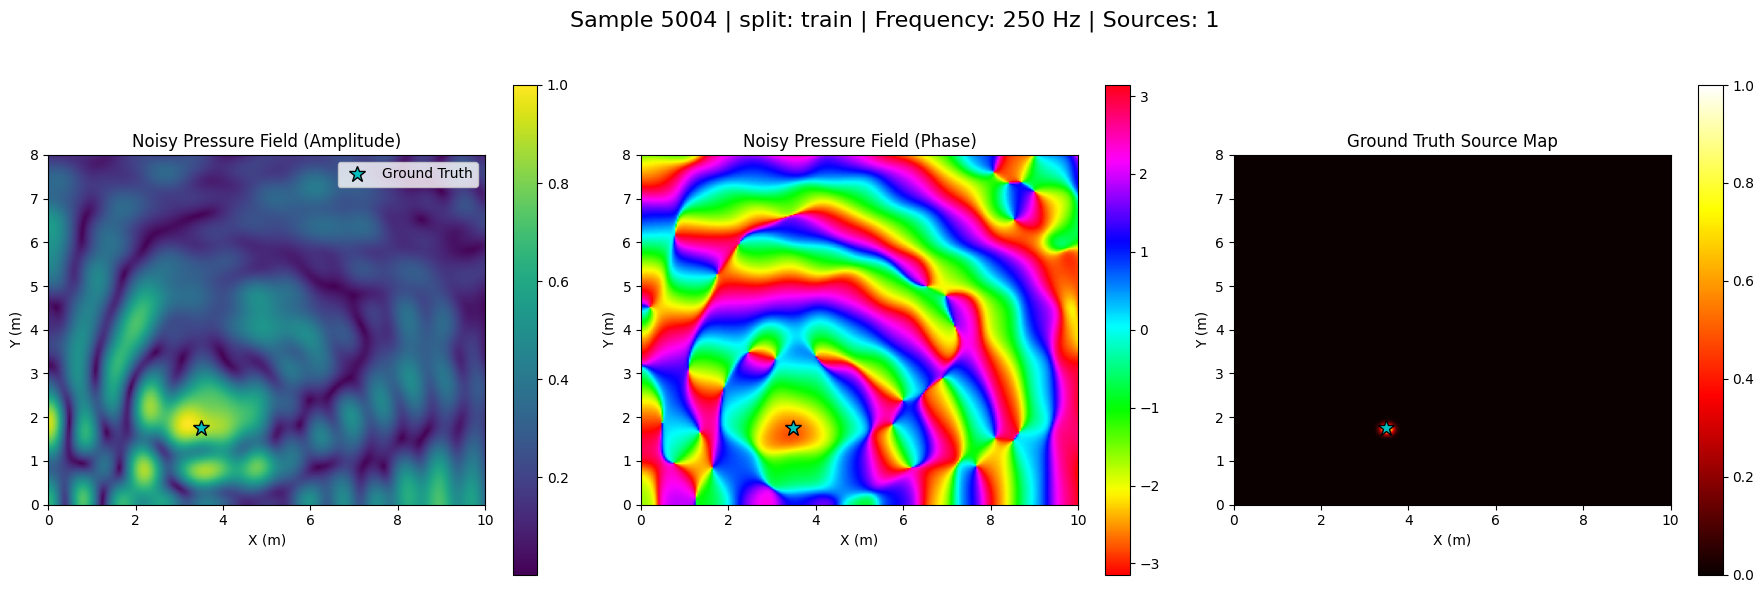

In [20]:
from acoustic_loc.utils import visualize_dataset_sample

PROJECT_DIR = "../."  # или полный путь

visualize_dataset_sample(PROJECT_DIR, sample_id=5004)


In [12]:
import glob

json_files = glob.glob("../data/metadata/json/sample_*_info.json")
print("JSON files:", len(json_files))

# посмотрим несколько сцен
for path in json_files[:3]:
    with open(path, "r", encoding="utf-8") as f:
        meta = json.load(f)
    print(
        Path(path).name,
        "freq:", meta["frequency"],
        "n_sources:", len(meta["sources"]),
        "first types:", [s["type"] for s in meta["sources"]][:3],
    )


JSON files: 10000
sample_000001_info.json freq: 8000 n_sources: 4 first types: ['music', 'machinery', 'impact']
sample_000002_info.json freq: 250 n_sources: 10 first types: ['music', 'music', 'impact']
sample_000003_info.json freq: 4000 n_sources: 8 first types: ['impact', 'impact', 'impact']


In [13]:
from collections import Counter

counts = Counter()
for path in json_files:
    with open(path, "r", encoding="utf-8") as f:
        meta = json.load(f)
    counts[len(meta["sources"])] += 1

counts


Counter({6: 1027,
         1: 1016,
         8: 1015,
         10: 1013,
         3: 1006,
         2: 998,
         4: 988,
         7: 986,
         9: 983,
         5: 968})

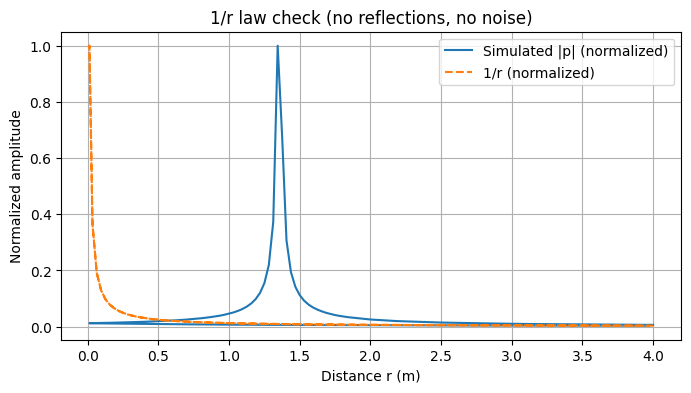

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from acoustic_loc.config import RoomConfig, GridConfig, SourcesConfig, AcousticsConfig, DatasetConfig, FullSimConfig
from acoustic_loc.simulator import AcousticSimulator

# Базовый конфиг (можно взять из YAML и руками чуть упростить)
room = RoomConfig(Lx=10.0, Ly=8.0, Lz=3.0, z_meas=1.5)
grid = GridConfig(nx=256, ny=256)
sources = SourcesConfig(
    n_min=1,
    n_max=1,
    margin_xy=0.3,
    z_min=1.5,
    z_max=1.5,
    types=["test"],
    spl_ranges={"test": [80.0, 80.0]},
    source_map_sigma_m=0.1,
)

acoustics = AcousticsConfig(
    c=343.0,
    freqs=[1000.0],
    alpha=0.0,
    floor_absorption=0.0,
    snr_db=None,
    ceiling_absorption=0.0,
    wall_absorption_x=0.0,
    wall_absorption_y=0.0,
    concrete_absorption_freq=None,
)

dataset = DatasetConfig(
    n_train=1,
    n_val=0,
    n_test=0,
    h5_out_dir="",
    json_out_dir="",
    source_map_sigma_m=0.1,
)

cfg = FullSimConfig(
    room=room,
    grid=grid,
    sources=sources,
    acoustics=acoustics,
    dataset=dataset,
)

sim = AcousticSimulator(cfg)

# Временно отключим image sources
sim.max_image_order = 0

p_complex, s_map, meta = sim.generate_scene()
p_mag = np.abs(p_complex)

# Берём срез по X через центр источника
H, W = p_mag.shape
ix_center = np.argmax(s_map.sum(axis=1))  # строка, где максимум по карте плотности
y = np.arange(W) * sim.dy
r = np.sqrt((y - sim.room_width / 2.0) ** 2 + (sim.measurement_height - meta["sources"][0]["position"]["z"])**2)

p_line = p_mag[ix_center, :]
p_line_norm = p_line / p_line.max()
theory = (1.0 / np.maximum(r, 0.01))
theory /= theory.max()

plt.figure(figsize=(8, 4))
plt.plot(r, p_line_norm, label="Simulated |p| (normalized)")
plt.plot(r, theory, "--", label="1/r (normalized)")
plt.xlabel("Distance r (m)")
plt.ylabel("Normalized amplitude")
plt.legend()
plt.grid(True)
plt.title("1/r law check (no reflections, no noise)")
plt.show()


In [22]:
# Два источника вместо одного
sim.max_image_order = 0

# Хак: сгенерируем сцену дважды и руками сложим два источника
src1 = sim._generate_source(frequency=1000.0)
src2 = sim._generate_source(frequency=1000.0)

p1 = sim._compute_pressure_field([src1], frequency=1000.0)
p2 = sim._compute_pressure_field([src2], frequency=1000.0)
p12 = sim._compute_pressure_field([src1, src2], frequency=1000.0)

rel_mse = np.mean(np.abs(p12 - (p1 + p2))**2) / np.mean(np.abs(p12)**2)
print("Relative MSE (superposition check):", rel_mse)


Relative MSE (superposition check): 0.0


Сэмпл 1 найден в 'train.h5' по индексу 6923.


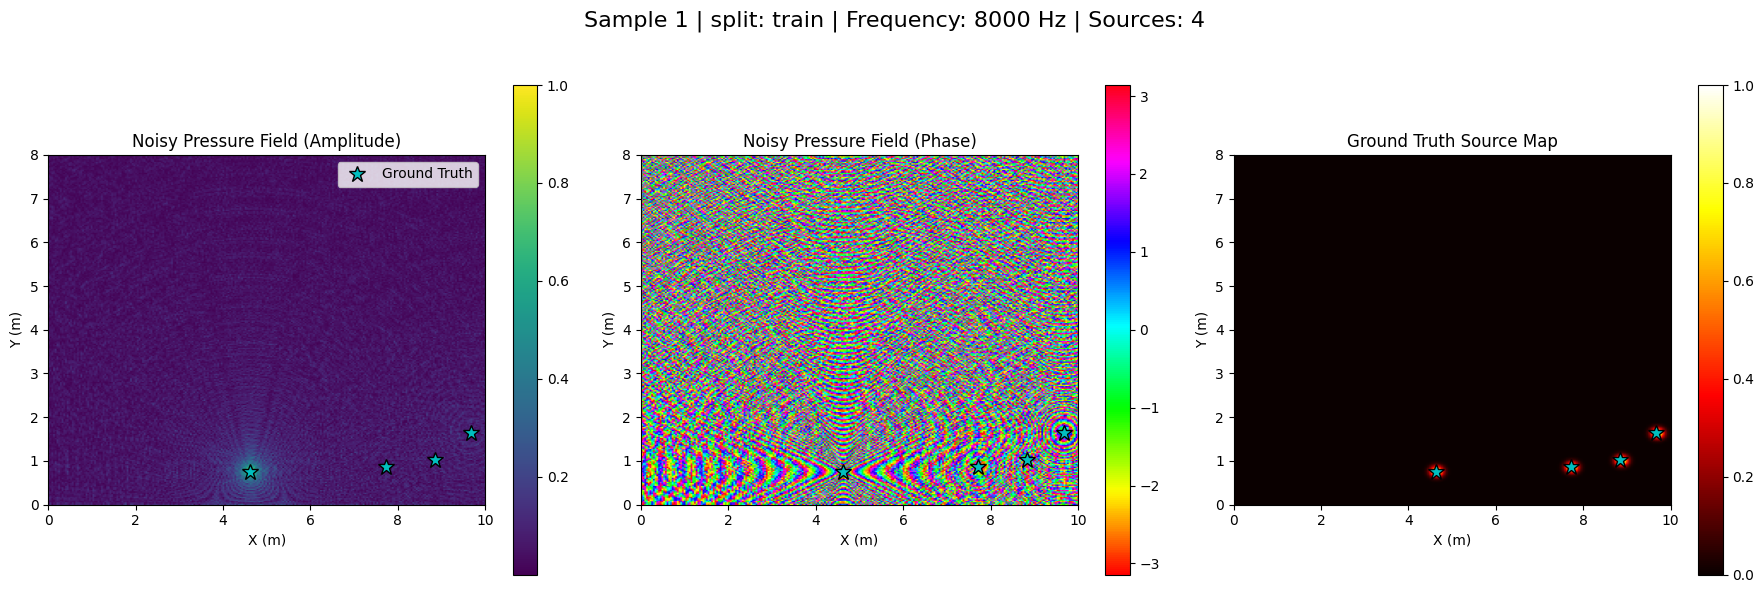

Сэмпл 2 найден в 'train.h5' по индексу 2458.


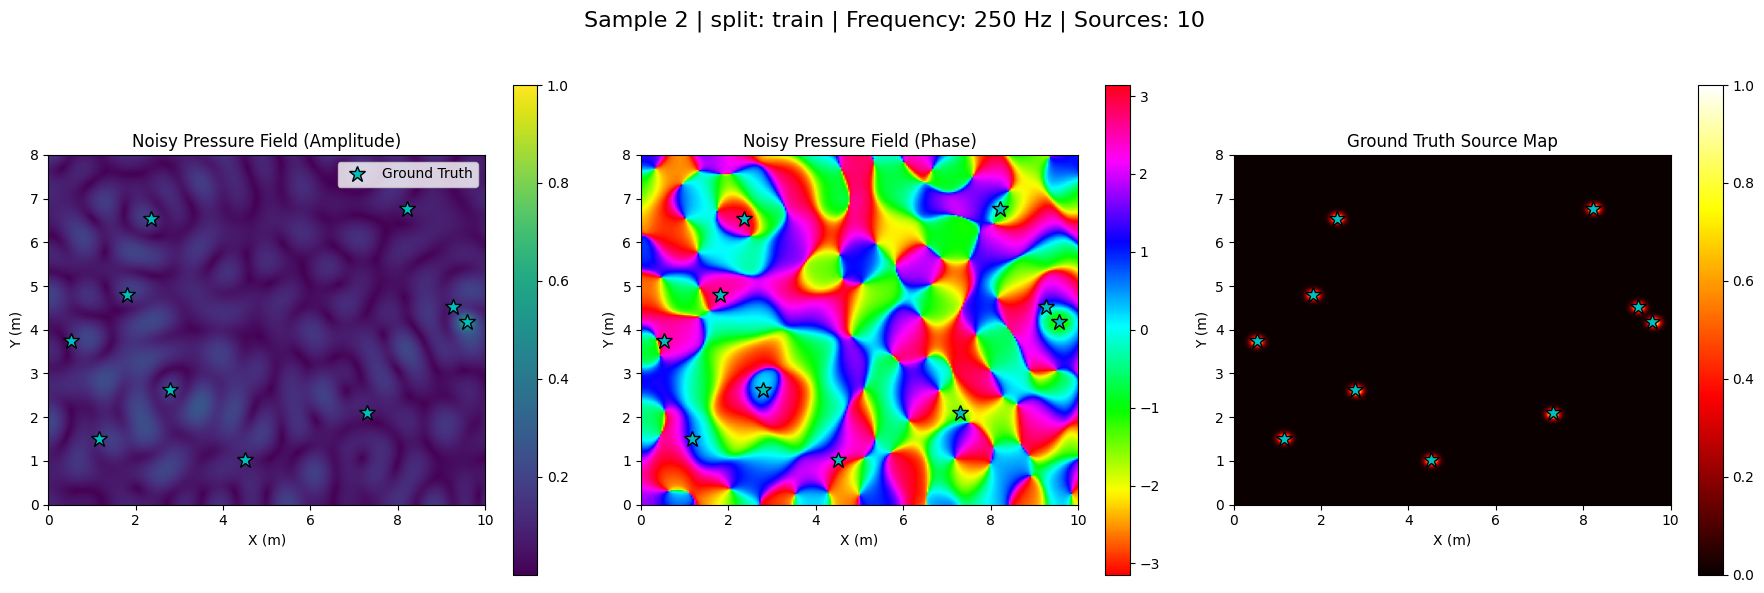

Сэмпл 100 найден в 'train.h5' по индексу 2543.


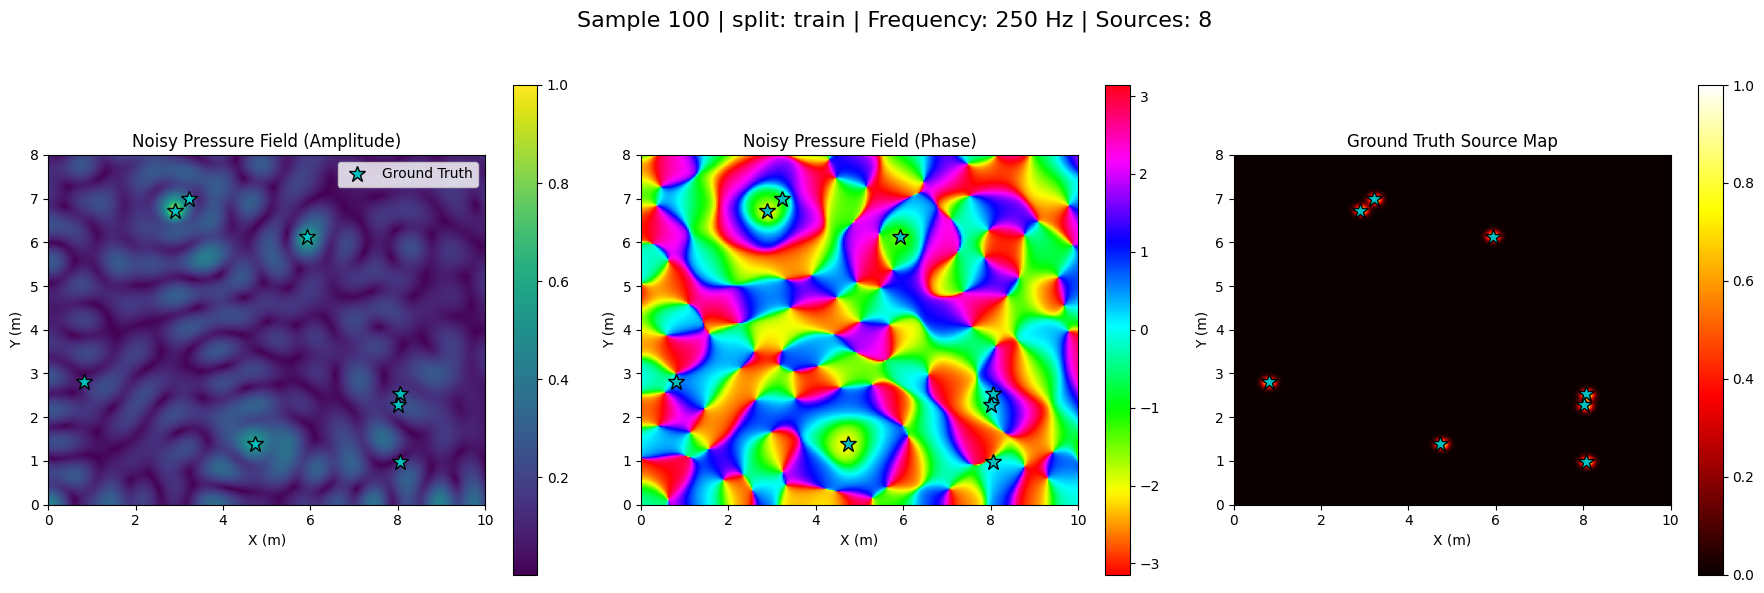

Сэмпл 500 найден в 'train.h5' по индексу 2994.


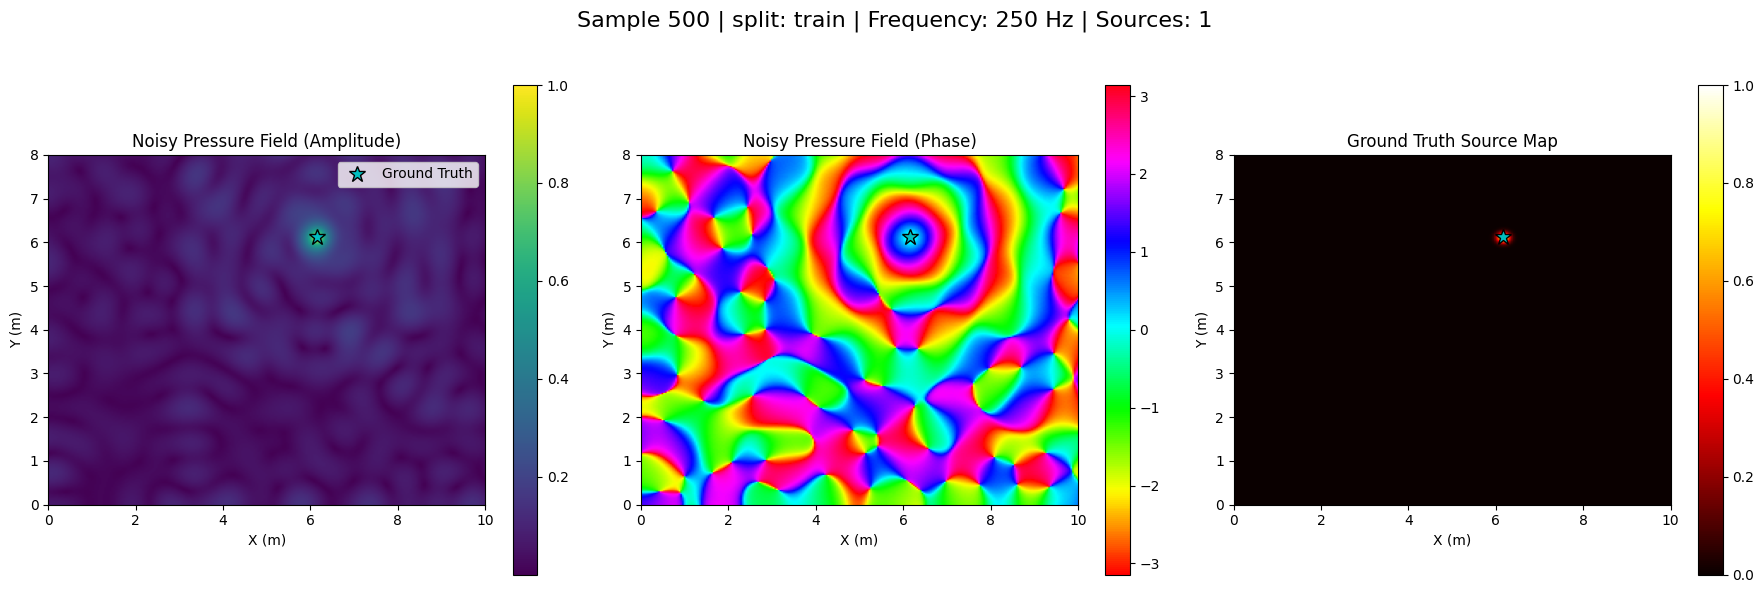

Сэмпл 999 найден в 'train.h5' по индексу 1840.


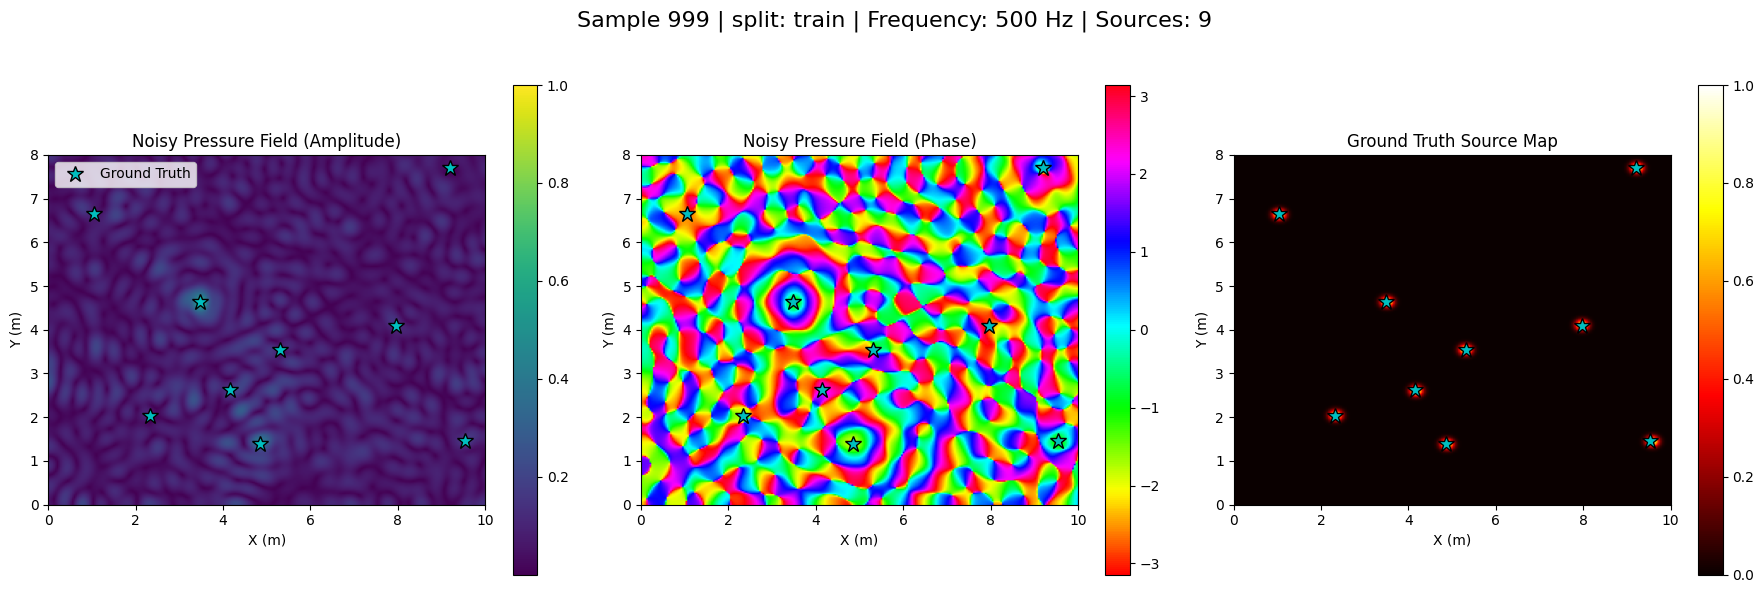

In [23]:
from acoustic_loc.utils import visualize_dataset_sample

# Возьми уже готовый датасет из H5
project_dir = "C:/GitProject/acoustic-source-localization"

# Например, визуализируем несколько сэмплов
for sid in [1, 2, 100, 500, 999]:
    visualize_dataset_sample(
        project_dir=project_dir,
        sample_id=sid,
        split=None,            # autodetect train/val/test
        cmap_field="viridis",
        cmap_phase="hsv",
        cmap_smap="hot",
        figsize=(18, 6),
    )


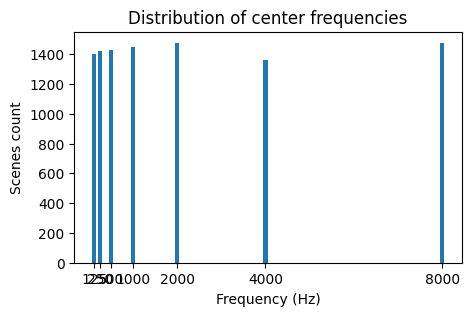

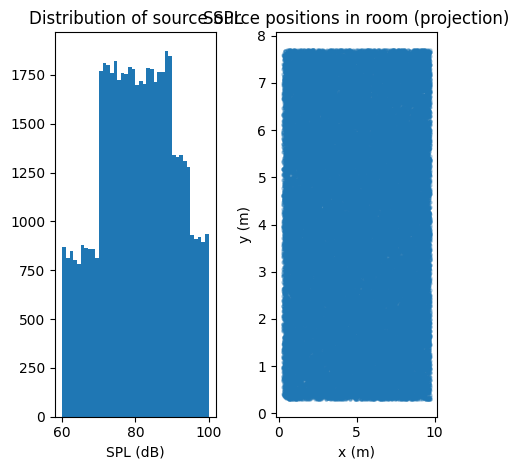

In [29]:
import json
import numpy as np
from pathlib import Path
import glob
import matplotlib.pyplot as plt

json_files = glob.glob("../data/metadata/json/sample_*_info.json")

freqs = []
spls = []
xs, ys, zs = [], [], []

for path in json_files:
    with open(path, "r", encoding="utf-8") as f:
        meta = json.load(f)
    freqs.append(meta["frequency"])
    for s in meta["sources"]:
        spls.append(s["spl_db"])
        xs.append(s["position"]["x"])
        ys.append(s["position"]["y"])
        zs.append(s["position"]["z"])

freqs = np.array(freqs)
spls = np.array(spls)
xs = np.array(xs)
ys = np.array(ys)
zs = np.array(zs)

unique_freqs, counts_freq = np.unique(freqs, return_counts=True)

plt.figure(figsize=(5,3))
plt.bar(unique_freqs, counts_freq, width=100)  # ширина ~ октавной полосы
plt.xticks(unique_freqs)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Scenes count")
plt.title("Distribution of center frequencies")
plt.show()


plt.subplot(1,3,2)
plt.hist(spls, bins=40)
plt.xlabel("SPL (dB)")
plt.title("Distribution of source SPL")

plt.subplot(1,3,3)
plt.scatter(xs, ys, s=5, alpha=0.3)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Source positions in room (projection)")
plt.tight_layout()
plt.show()


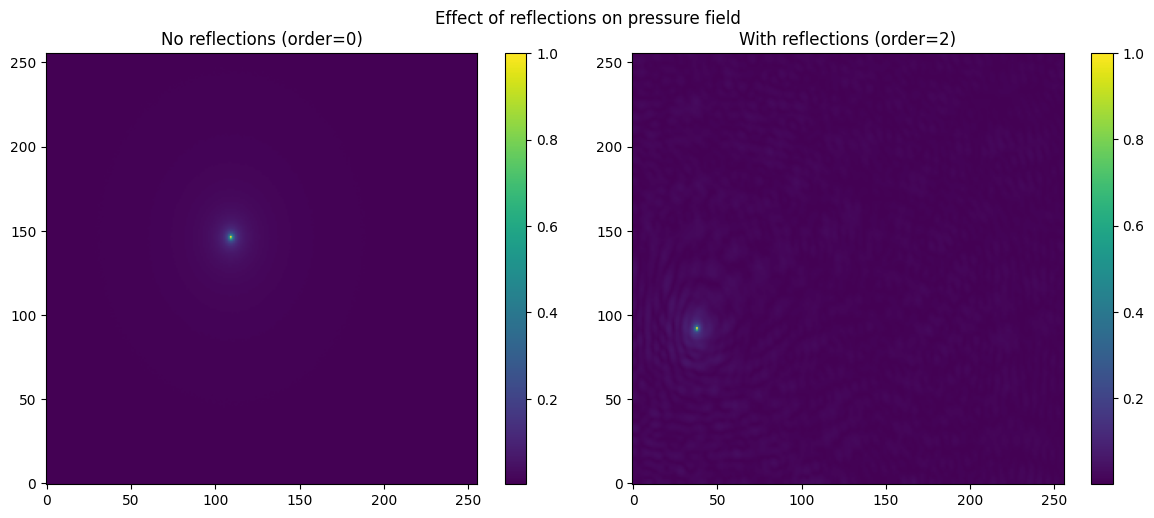

In [25]:
# один и тот же источник, но с max_image_order=0 и 2
sim_no_refl = AcousticSimulator(cfg)
sim_no_refl.max_image_order = 0
p0, s0, _ = sim_no_refl.generate_scene()

sim_refl = AcousticSimulator(cfg)
sim_refl.max_image_order = 2
p2, s2, _ = sim_refl.generate_scene()

mag0 = np.abs(p0)
mag2 = np.abs(p2)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
im0 = axes[0].imshow(mag0.T / mag0.max(), origin="lower", cmap="viridis")
axes[0].set_title("No reflections (order=0)")
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(mag2.T / mag2.max(), origin="lower", cmap="viridis")
axes[1].set_title("With reflections (order=2)")
plt.colorbar(im1, ax=axes[1])

plt.suptitle("Effect of reflections on pressure field")
plt.tight_layout()
plt.show()
